In [57]:
from Paisley_Algorithm import * 
from scipy.io import arff
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessClassifier
from os.path  import join
from datafold.pcfold import PCManifold
from datafold.pcfold import kernels
from datafold.pcfold import estimate_scale
import GPy
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import sys
from numpy import linalg as LA
from sklearn.decomposition import PCA

In [2]:
path ="C:/Users/anany/Desktop/master_thesis-master/DuckDuckGeese/DuckDuckGeese_TRAIN.arff"
soundlist = pd.DataFrame()
data, meta = arff.loadarff(path)
df = pd.DataFrame(data)

In [3]:
I, J, K = 50, 1345, 270
data = np.zeros((I, J * K))
for i in range(I):
    arr = np.zeros((J, K))
    for j in range(J):
        for k in range(K):
            arr[j][k] = df['relationalAtt'][i][j][k]
    arr = arr.reshape(1, -1)
    data[i] = arr
data = np.array(data)
data.shape

(50, 363150)

In [6]:
path ="C:/Users/anany/Desktop/master_thesis-master/DuckDuckGeese/DuckDuckGeese_TEST.arff"
soundlist_test = pd.DataFrame()
data_test, meta = arff.loadarff(path)
df_test = pd.DataFrame(data_test)

In [7]:
I, J, K = 50, 1345, 270
data_test = np.zeros((I, J * K))
for i in range(I):
    arr_test = np.zeros((J, K))
    for j in range(J):
        for k in range(K):
            arr_test[j][k] = df_test['relationalAtt'][i][j][k]
    arr_test = arr_test.reshape(1, -1)
    data_test[i] = arr_test
data_test = np.array(data_test)
data_test.shape

(50, 363150)

In [8]:
y_train = []

for i in range(50):
    y_train.append(df['target'][i])
y_test = []

for i in range(50):
    y_test.append(df_test['target'][i])

In [9]:
y = y_train + y_test
y = np.array(y)
y = y.reshape(y.shape[0], 1)
y.shape

(100, 1)

In [11]:
labels = {'Black-bellied_Whistling_Duck': 1,'Canadian_Goose': 2, 'Greylag_Goose': 3, 'Pink-footed_Goose': 4, 
          'White-faced_Whistling_Duck' : 5} 
y = [labels[item[0].decode('ascii')] for item in y]
y = np.array(y)
X = np.concatenate((data, data_test))

In [131]:
X_normed = X
X_normed = (X_normed) / (np.max(X_normed) - np.min(X_normed))

In [132]:
temp_x = X

pca = PCA(n_components=100)
temp_x = pca.fit_transform(X_normed)

In [133]:
pca.explained_variance_ratio_

array([2.35233932e-01, 6.28999355e-02, 5.87523964e-02, 5.47609950e-02,
       4.58667956e-02, 3.24626380e-02, 3.03801734e-02, 2.83430706e-02,
       2.57486827e-02, 2.38176225e-02, 2.26030743e-02, 2.11545998e-02,
       1.90835423e-02, 1.71748132e-02, 1.68322547e-02, 1.56432950e-02,
       1.47305161e-02, 1.34353542e-02, 1.27861129e-02, 1.20263099e-02,
       1.16409785e-02, 1.05209522e-02, 1.03473044e-02, 9.48105397e-03,
       9.12311488e-03, 8.89897677e-03, 8.71934701e-03, 8.45734960e-03,
       8.25086989e-03, 7.95393443e-03, 7.68810748e-03, 7.30580803e-03,
       7.23902977e-03, 7.05381937e-03, 6.01789493e-03, 5.75877430e-03,
       5.56521837e-03, 5.50354799e-03, 4.96748010e-03, 4.79196351e-03,
       4.62693959e-03, 4.53543950e-03, 4.18931699e-03, 3.63391212e-03,
       3.58478452e-03, 3.42331029e-03, 3.28894773e-03, 3.14745940e-03,
       2.93593876e-03, 2.77476120e-03, 2.69644301e-03, 2.60790467e-03,
       2.43152386e-03, 2.39689789e-03, 2.20712503e-03, 2.05703776e-03,
      

In [101]:
np.sum(pca.explained_variance_ratio_)

0.8570402652980461

In [102]:
temp_x.shape

(100, 30)

In [134]:
n_classes = 5

random_state = 42
test_size = 0.2
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
X_train, X_test, y_train, y_test = train_test_split(temp_x, y, test_size=test_size, random_state=random_state)

print("Classes: ", np.unique(y_train))
print("Number of points per class:", [np.sum(y_train==k) for k in np.unique(y_train)])

Classes:  [1 2 3 4 5]
Number of points per class: [17, 17, 15, 14, 17]


In [135]:
count = np.zeros(10)
tot_landmarks = np.array([])
labels = []
x = []
for j in range(1, 6):
    cat_data = []
    new_labels = []
    for i in range(y_train.shape[0]):
        if (y_train[i] == j and count[y_train[i]] < 10):
            new_labels.append(y_train[i])
            cat_data.append(X_train[i])
            count[y_train[i]] += 1
    print(np.array(cat_data).shape)
    new_labels = np.array(new_labels)
    cat_data = np.array(cat_data)
    if j==1:
        mgp = ManifoldGP(n_landmarks=5, landmarks=None)
    else:
        mgp = ManifoldGP(n_landmarks=5, landmarks=tot_landmarks)
    mgp.learn_landmarks(cat_data, batch_size = 10)
    tot_landmarks = mgp.landmarks
    print(tot_landmarks.shape)
    labels.append(new_labels)
    x.append(cat_data)
tot_landmarks = np.array(tot_landmarks)
#tot_landmarks = tot_landmarks.reshape(-1, )
labels = np.array(labels)
labels = labels.reshape(-1, 1)
x = np.array(x)
#x = x.reshape(500,64)
x.shape

(10, 100)
bandwidth:  0.42099820750634687
Learning landmark 0:
Progress: 1000/1000
Learning landmark 1:
Progress: 250/1000

 <ipython-input-48-e3e861f6d372>:133: FutureWarning:`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Progress: 1000/1000
Learning landmark 2:
Progress: 1000/1000
Learning landmark 3:
Progress: 1000/1000
Learning landmark 4:
Progress: 1000/1000
(5, 100)
(10, 100)
bandwidth:  0.9412058828937133
Learning landmark 0:
Progress: 200/1000

 <ipython-input-48-e3e861f6d372>:133: FutureWarning:`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Progress: 1000/1000
Learning landmark 1:
Progress: 1000/1000
Learning landmark 2:
Progress: 1000/1000
Learning landmark 3:
Progress: 1000/1000
Learning landmark 4:
Progress: 1000/1000
(10, 100)
(10, 100)
bandwidth:  2.555595437167477
Learning landmark 0:
Progress: 200/1000

 <ipython-input-48-e3e861f6d372>:133: FutureWarning:`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Progress: 1000/1000
Learning landmark 1:
Progress: 1000/1000
Learning landmark 2:
Progress: 1000/1000
Learning landmark 3:
Progress: 1000/1000
Learning landmark 4:
Progress: 1000/1000
(15, 100)
(10, 100)
bandwidth:  0.7467937368031149
Learning landmark 0:
Progress: 100/1000

 <ipython-input-48-e3e861f6d372>:133: FutureWarning:`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Progress: 1000/1000
Learning landmark 1:
Progress: 1000/1000
Learning landmark 2:
Progress: 1000/1000
Learning landmark 3:
Progress: 1000/1000
Learning landmark 4:
Progress: 1000/1000
(20, 100)
(10, 100)
bandwidth:  1.2536974889357753
Learning landmark 0:
Progress: 100/1000

 <ipython-input-48-e3e861f6d372>:133: FutureWarning:`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Progress: 1000/1000
Learning landmark 1:
Progress: 1000/1000
Learning landmark 2:
Progress: 1000/1000
Learning landmark 3:
Progress: 1000/1000
Learning landmark 4:
Progress: 1000/1000
(25, 100)


(5, 10, 100)

In [136]:
x = x.reshape(50,100)

In [137]:
tot_landmarks.shape

(25, 100)

In [138]:
encoder = OneHotEncoder(sparse=False)
onehot = encoder.fit_transform(labels.reshape(-1, 1))
onehot

array([[1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0.

In [139]:
number_of_classes = 5
m = [GPy.models.GPClassification(x,onehot[:,i].reshape(-1,1)) for i in range(0, number_of_classes)]

In [140]:
for m_ in m:
    m_.optimize()
average_variance = np.average([m_.rbf.variance[0] for m_ in m])
average_lengthscale = np.average([m_.rbf.lengthscale[0] for m_ in m])

In [141]:
kernel = average_variance * RBF(average_lengthscale)
gpc_true = GaussianProcessClassifier(kernel=kernel,random_state=0).fit(x, labels)

 C:\Users\anany\Anaconda3\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning:A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [142]:
def landmark_gp_clustering_accuracy(gpc_true, landmarks, coords, y):
    if(landmarks.shape[0] < 2):
        return 0
    kernel = average_variance * RBF(average_lengthscale)
    landmark_labels = gpc_true.predict(landmarks)
    gpc = GaussianProcessClassifier(kernel=kernel,random_state=0, max_iter_predict = 1000).fit(landmarks, landmark_labels)
    predicted_labels = gpc.predict(coords)
    print("Landmarks: ", landmarks.shape[0], "Accuracy: ", accuracy_score(y, predicted_labels))
    return accuracy_score(y, predicted_labels)

In [144]:
np.random.shuffle(tot_landmarks)

In [145]:
accuracies_gp = [landmark_gp_clustering_accuracy(gpc_true, tot_landmarks[:i, :], X_test, y_test) for i in range(0, tot_landmarks.shape[0], 1)]

Landmarks:  2 Accuracy:  0.3
Landmarks:  3 Accuracy:  0.3
Landmarks:  4 Accuracy:  0.3
Landmarks:  5 Accuracy:  0.3
Landmarks:  6 Accuracy:  0.3
Landmarks:  7 Accuracy:  0.3
Landmarks:  8 Accuracy:  0.3
Landmarks:  9 Accuracy:  0.3
Landmarks:  10 Accuracy:  0.3
Landmarks:  11 Accuracy:  0.3
Landmarks:  12 Accuracy:  0.3
Landmarks:  13 Accuracy:  0.3
Landmarks:  14 Accuracy:  0.3
Landmarks:  15 Accuracy:  0.3
Landmarks:  16 Accuracy:  0.3
Landmarks:  17 Accuracy:  0.3
Landmarks:  18 Accuracy:  0.3
Landmarks:  19 Accuracy:  0.3
Landmarks:  20 Accuracy:  0.3
Landmarks:  21 Accuracy:  0.3
Landmarks:  22 Accuracy:  0.3
Landmarks:  23 Accuracy:  0.3
Landmarks:  24 Accuracy:  0.3


In [146]:
def landmark_clustering_accuracy(landmarks, coords, y):
    if(landmarks.shape[0] < 2):
        return 0
    knn_true = KNeighborsClassifier(n_neighbors=1).fit(coords, y)
    landmark_labels = knn_true.predict(landmarks)
    knn_land = KNeighborsClassifier(n_neighbors=1).fit(landmarks, landmark_labels)
    predicted_labels = knn_land.predict(coords)
    print("Landmarks: ", landmarks.shape[0], "Accuracy: ", accuracy_score(y, predicted_labels))
    return accuracy_score(y, predicted_labels)

In [147]:
accuracies_knn = [landmark_clustering_accuracy(tot_landmarks[:i, :], X_test, y_test) for i in range(0, tot_landmarks.shape[0], 1)]

Landmarks:  2 Accuracy:  0.3
Landmarks:  3 Accuracy:  0.3
Landmarks:  4 Accuracy:  0.3
Landmarks:  5 Accuracy:  0.3
Landmarks:  6 Accuracy:  0.3
Landmarks:  7 Accuracy:  0.3
Landmarks:  8 Accuracy:  0.3
Landmarks:  9 Accuracy:  0.3
Landmarks:  10 Accuracy:  0.35
Landmarks:  11 Accuracy:  0.35
Landmarks:  12 Accuracy:  0.35
Landmarks:  13 Accuracy:  0.35
Landmarks:  14 Accuracy:  0.4
Landmarks:  15 Accuracy:  0.4
Landmarks:  16 Accuracy:  0.4
Landmarks:  17 Accuracy:  0.4
Landmarks:  18 Accuracy:  0.35
Landmarks:  19 Accuracy:  0.35
Landmarks:  20 Accuracy:  0.35
Landmarks:  21 Accuracy:  0.35
Landmarks:  22 Accuracy:  0.4
Landmarks:  23 Accuracy:  0.4
Landmarks:  24 Accuracy:  0.4


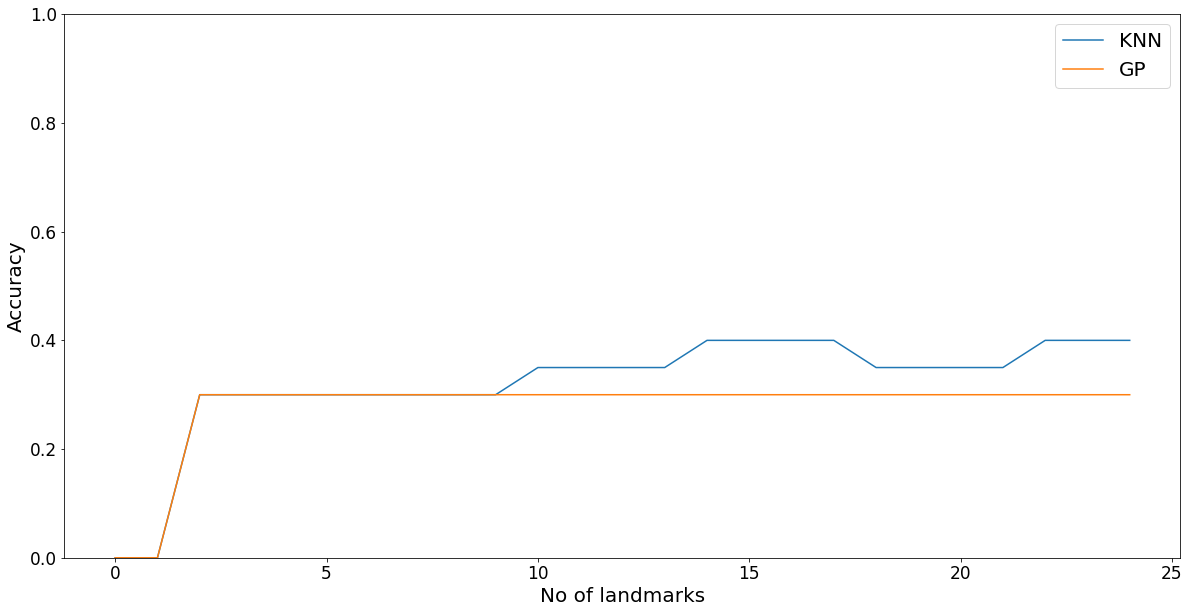

In [149]:
fig = plt.figure(figsize=(20, 10))
plt.plot(range(0, tot_landmarks.shape[0], 1), accuracies_knn, label = "KNN")
plt.plot(range(0, tot_landmarks.shape[0], 1), accuracies_gp, label = "GP")
plt.xlabel('No of landmarks' ,fontsize=20)
plt.ylabel('Accuracy' ,fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=17)
plt.legend(fontsize=20)
plt.ylim(0, 1.0)
plt.show()
fig.savefig('conc_landmarks_paisley_tsne_duckduckgeese.png')